В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

Area under ROC score on Training dataset: 0.90%


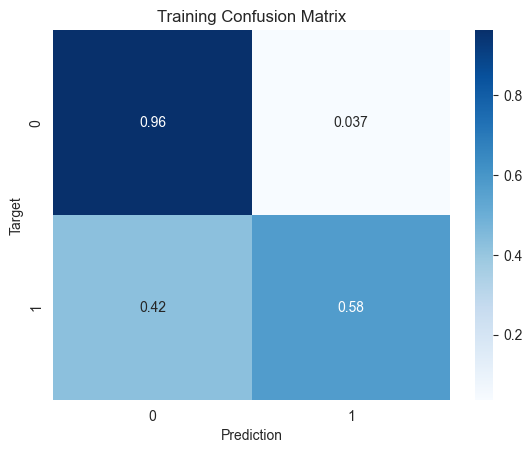

Area under ROC score on Validation dataset: 0.88%


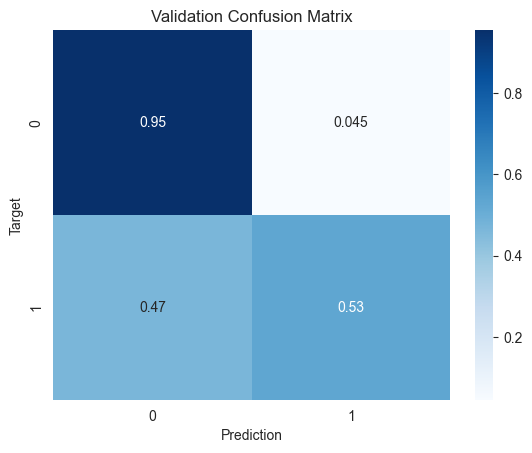

['models/model_pipeline_no_polynom.joblib']

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings

from sympy import print_glsl

warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import joblib


clients_df = pd.read_csv('csv/train.csv')

# Drop ClientId column
clients_df.drop(['CustomerId'], axis=1, inplace=True)

# Split into train test and validation dataframes
use_sample = False
train_val_df, test_df = train_test_split(clients_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(clients_df, test_size=0.25, random_state=42)

# Create train and target columns dataframes
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()


# Find numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()


# Створюємо трансформери для числових і категоріальних колонок

class ColumnCaster(BaseEstimator, TransformerMixin):
    """Transformer that converts specified columns to int."""
    def __init__(self, int_cols=None):
        self.int_cols = int_cols if int_cols is not None else []
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for col in self.int_cols:
            if col in X.columns:
                X[col] = X[col].astype(int)
        return X

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # data imputing
    ('scaler', MinMaxScaler()) #data scaling
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# # Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline_no_polynom = Pipeline(steps=[
    ('col_cast', ColumnCaster(int_cols=['Age','Tenure','NumOfProducts','HasCrCard'])),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)

    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")

    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()

    return preds

# Тренуємо пайплайн
model_pipeline_no_polynom.fit(train_inputs, train_targets)

# Оцінюємо модель на тренувальних і вал даних
train_preds = predict_and_plot(model_pipeline_no_polynom, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline_no_polynom, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline_no_polynom, 'models/model_pipeline_no_polynom.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Training dataset: 0.95%


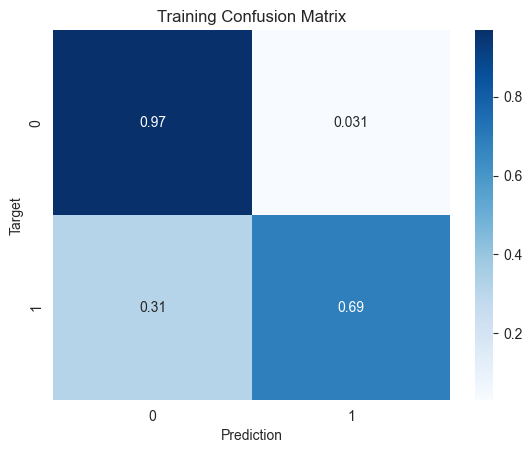

Area under ROC score on Validation dataset: 0.92%


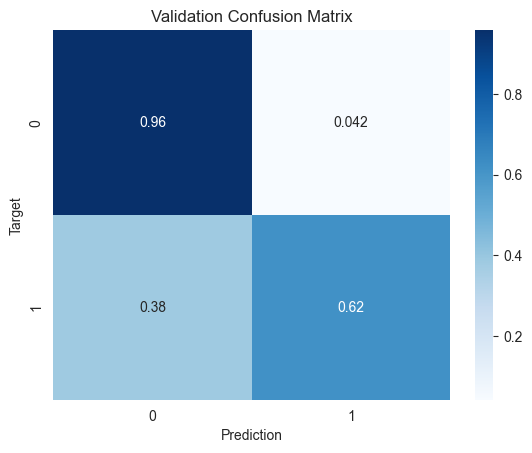

In [3]:
from sklearn.preprocessing import PolynomialFeatures


numeric_transformer_polynom_3 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False))  # Only numeric
])

# categorical_transformer remains as is, no polynomial expansion
categorical_transformer_polynom_3 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor_polynom_3 = ColumnTransformer([
    ('num', numeric_transformer_polynom_3, numeric_cols),
    ('cat', categorical_transformer_polynom_3, categorical_cols)
])

model_pipeline_polynom_3 = Pipeline([
    ('col_cast', ColumnCaster(int_cols=['Age','Tenure','NumOfProducts','HasCrCard'])),
    ('preprocessor', preprocessor_polynom_3),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline_polynom_3.fit(train_inputs, train_targets)

# Оцінюємо модель на тренувальних і вал даних
train_preds_polynom_3 = predict_and_plot(model_pipeline_polynom_3, train_inputs, train_targets, 'Training')
val_preds_polynom_3 = predict_and_plot(model_pipeline_polynom_3, val_inputs, val_targets, 'Validation')



Як бачимо, ця модель впоралася краще ніж попередня: 0.92% точності проти 0.88% у попередньої.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Training dataset: 0.95%


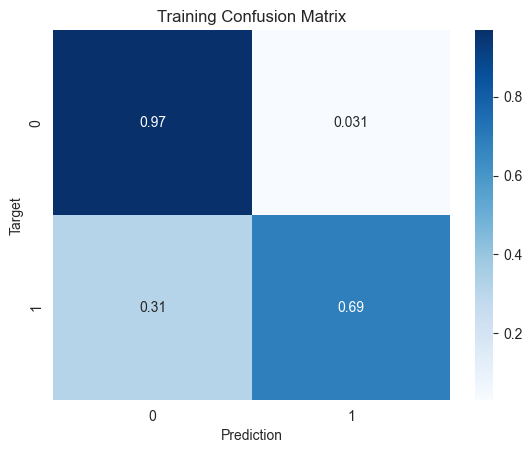

Area under ROC score on Validation dataset: 0.92%


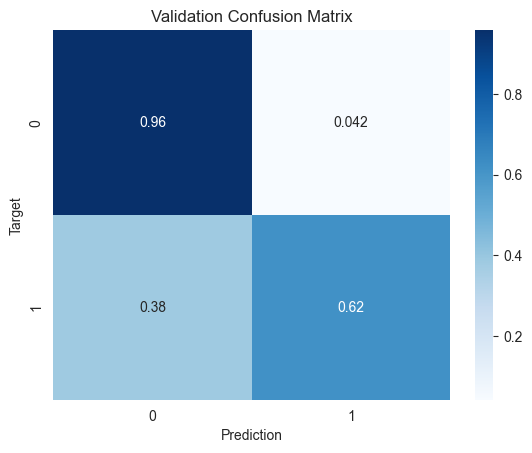

In [4]:
from sklearn.preprocessing import PolynomialFeatures


numeric_transformer_polynom_4 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False))  # Only numeric
])

# categorical_transformer remains as is, no polynomial expansion
categorical_transformer_polynom_4 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor_polynom_4 = ColumnTransformer([
    ('num', numeric_transformer_polynom_4, numeric_cols),
    ('cat', categorical_transformer_polynom_4, categorical_cols)
])

model_pipeline_polynom_4 = Pipeline([
    ('col_cast', ColumnCaster(int_cols=['Age','Tenure','NumOfProducts','HasCrCard'])),
    ('preprocessor', preprocessor_polynom_3),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline_polynom_4.fit(train_inputs, train_targets)

# Оцінюємо модель на тренувальних і вал даних
train_preds_polynom_4 = predict_and_plot(model_pipeline_polynom_4, train_inputs, train_targets, 'Training')
val_preds_polynom_4 = predict_and_plot(model_pipeline_polynom_4, val_inputs, val_targets, 'Validation')

Показники цієї моделі ідентичні попереднім. Виходить, що підвищення спеню поліноміальних ознак більше 3 не впливає на точніть моделі позитивним чином.

In [ ]:
# Using polynomial model on my submission dataset

numeric_transformer_polynom_submission = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=15, include_bias=False))  # Only numeric
])

# categorical_transformer remains as is, no polynomial expansion
categorical_transformer_polynom_submission = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor_polynom_submission = ColumnTransformer([
    ('num', numeric_transformer_polynom_submission, numeric_cols),
    ('cat', categorical_transformer_polynom_submission, categorical_cols)
])

model_pipeline_polynom_submission = Pipeline([
    ('col_cast', ColumnCaster(int_cols=['Age','Tenure','NumOfProducts','HasCrCard'])),
    ('preprocessor', preprocessor_polynom_submission),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline_polynom_submission.fit(train_inputs, train_targets)

submission_df = pd.read_csv('csv/test.csv')

submission_inputs = submission_df[input_cols].copy()
preds = model_pipeline_polynom_submission.predict(submission_inputs)
pred_proba = model_pipeline_polynom_submission.predict_proba(submission_inputs)
# pred_proba[pred_proba < 0.5] = 0
exited_predictions = np.argmax(pred_proba, axis=1)
submission_df['Exited'] = exited_predictions

sample_submission_df = pd.read_csv('csv/sample_submission.csv')
merged_df = sample_submission_df.merge(
    submission_df[['id', 'Exited']],
    on='id',
    how='left'
)

merged_df = merged_df.drop(columns=['Exited_x'])
merged_df = merged_df.rename(columns={'Exited_y': 'Exited'})

merged_df.to_csv('csv/submission.csv', index=False)

merged_df

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

regression_df = pd.read_csv('csv/regression_data.csv')
print(regression_df.shape)
regression_df


(129, 6)


,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013
...,...,...,...,...,...,...
124,1.402794,0.586857,-1.401851,0.791032,-0.909387,39.626185
125,-0.288659,-0.827231,0.322719,-1.002529,-0.018513,-50.585687
126,-1.407464,-0.213447,-0.718444,0.232050,-1.448084,13.719861
127,1.353872,1.237816,-0.114540,-0.469176,-1.713135,-23.851350


In [5]:


X = regression_df.iloc[:, :-1]
y = regression_df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model_pipeline_regression = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('classifier', LinearRegression())
])

model_pipeline_regression.fit(X_train, y_train)
y_pred_train_poly = model_pipeline_regression.predict(X_train)
y_pred_val_poly = model_pipeline_regression.predict(X_val)

rmse_poly_train = mean_squared_error(y_train, y_pred_train_poly, squared=False)
rmse_poly_val   = mean_squared_error(y_val,   y_pred_val_poly,   squared=False)

print(f"Train RMSE: {rmse_poly_train:.3f}")
print(f"Val   RMSE: {rmse_poly_val:.3f}")

Train RMSE: 0.000
Val   RMSE: 16.035


На мою думку, модель погано генералізує.
Тут ми бачимо класичний приклад перенавчання - 0 помилка на Train датасеті та велика помилка на Validation датасеті. Думаю, що модель просто "запамʼятала" тренувальні дані і зовсім не зрозуміла валідаційні.
Також треба враховувати, що датасет доволі малий, поліноміальна регресія зі в степені 5 згенерує багато додаткових фіч.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [6]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    LinearRegression(),
    Ridge(alpha=1),
    Ridge(alpha=2),
    Lasso(),
]

def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_metrics = mean_squared_error(y_train, y_train_pred, squared=False).round(6)
    val_metrics = mean_squared_error(y_val, y_val_pred, squared=False).round(6)

    return dict(train=train_metrics, val=val_metrics)

X_train

,feature_1,feature_2,feature_3,feature_4,feature_5
70,0.791663,0.628346,0.624120,-1.214189,1.158111
78,0.311250,1.119575,3.078881,-0.249036,0.576557
47,0.871125,1.201214,-0.326024,0.289775,2.075401
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246
12,-0.653329,0.404982,1.765454,-0.334501,-0.474945
...,...,...,...,...,...
106,-0.248964,0.645376,0.971571,2.060748,1.755341
14,-0.342715,-0.161286,-0.802277,-1.415371,-0.420645
92,0.214094,0.173181,-1.245739,-0.446515,0.856399
51,-0.236819,0.081874,-0.485364,0.758969,-0.772825


In [7]:
degrees = list(range(1, 21))
best_model = 'LinearRegression'
best_train_metrics = float('inf')
best_val_metrics = float('inf')
best_degree = degrees[0]

for degree in degrees:
    print(f'degree: {degree}')

    for model in models:
        poly_features = PolynomialFeatures(degree)
        X_train_poly = poly_features.fit_transform(X_train)
        X_val_poly = poly_features.transform(X_val)
        model.fit(X_train_poly, y_train)
        eval_results  = evaluate_model(model, X_train_poly, y_train, X_val_poly, y_val)

        if(best_train_metrics and best_val_metrics == float('inf')):
            best_model = str(model)
            best_train_metrics = eval_results['train']
            best_val_metrics = eval_results['val']
            best_degree = degree

        if(abs(eval_results['train'] - eval_results['val']) < abs(best_train_metrics - best_val_metrics)):
            best_model = str(model)
            best_train_metrics = eval_results['train']
            best_val_metrics = eval_results['val']
            best_degree = degree


        print(f'{str(model)}: {eval_results}\n')

print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n')
print(f'Best model: {best_model}\n')
print(f'Best metrics: train -{best_train_metrics},  val -{best_val_metrics}\n')
print(f'Best degree: {best_degree}\n')

degree: 1
LinearRegression(): {'train': 1.066472, 'val': 0.883327}

Ridge(alpha=1): {'train': 1.197553, 'val': 0.992599}

Ridge(alpha=2): {'train': 1.515007, 'val': 1.380979}

Lasso(): {'train': 1.571223, 'val': 1.512621}

degree: 2
LinearRegression(): {'train': 1.01665, 'val': 1.014851}

Ridge(alpha=1): {'train': 1.170678, 'val': 1.2341}

Ridge(alpha=2): {'train': 1.529127, 'val': 1.725789}

Lasso(): {'train': 1.571223, 'val': 1.512621}

degree: 3
LinearRegression(): {'train': 0.799271, 'val': 1.91596}

Ridge(alpha=1): {'train': 1.80872, 'val': 7.881783}

Ridge(alpha=2): {'train': 2.820853, 'val': 11.685399}

Lasso(): {'train': 1.869197, 'val': 1.936133}

degree: 4
LinearRegression(): {'train': 0.0, 'val': 19.270418}

Ridge(alpha=1): {'train': 1.536994, 'val': 27.095885}

Ridge(alpha=2): {'train': 2.398306, 'val': 23.698184}

Lasso(): {'train': 1.876348, 'val': 2.018909}

degree: 5
LinearRegression(): {'train': 0.0, 'val': 29.433497}

Ridge(alpha=1): {'train': 1.258071, 'val': 29.4898

Як бачимо, краще за всіх генералізує Лінійна регресія з поліноміальними фічами 2 степеня.
Далі генералізація починає падати.
Моя думка така, що коли степень поліноміальних фіч починає рости, то колонок стає більше ніж рядків.
На початку у нас є лише 103 рядки і 5 колонок.
А у випадку степеня 3 і більше колонок стає вже більше десяти. Тобто модель перенавчається вловлюючи навіть шуми. І тому на валідаційних даних вона працює дуже погано.